# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [10-1 portfolio](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
preds['y_true_full'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return
data_raw = pd.read_csv('data/data.csv')
omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])
omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]
omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 
omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where((df['in_cb'].isna()) & (df['in_c25'] == True), True, df['in_cb'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

df = df[df['in_c25'] == True]

# <a id='toc4_'></a>[10-1 portfolio](#toc0_)

In [4]:
# create deciles
df['decile_ols'] = df.groupby(['timestamp'])['ols'].transform(deciles)
df['decile_lasso'] = df.groupby(['timestamp'])['lasso'].transform(deciles)
df['decile_mlp'] = df.groupby(['timestamp'])['mlp'].transform(deciles)
df['decile_mlp-pyr'] = df.groupby(['timestamp'])['mlp-pyr'].transform(deciles)
df['decile_naive'] = 9


In [5]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = {
    'ols':      'decile_ols',
    'lasso':    'decile_lasso',
    'mlp':      'decile_mlp',
    'mlp-pyr':  'decile_mlp-pyr'
}

tmp_dfs = {}

for model, decile in models.items():
    tmp = df.copy(deep=True)
    tmp = tmp[['timestamp', 'ticker', decile, 'y_true_full']]

    tmp['action'] = np.where(tmp[decile] == 0, -1, np.where(tmp[decile] == 9, 1, 0))

    tmp['n_short'] = (tmp['action'] == -1).astype(int)
    tmp['n_long'] = (tmp['action'] == 1).astype(int)


    tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
    tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')

    tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],
                            np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'], 0))

    # pure one-way long/short portfolio
    # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],0)
    # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_long'],0)


    tmp_df = tmp.copy(deep=True)
    # drop rows with action == 0
    tmp_df = tmp_df[tmp_df['action'] != 0]
    tmp_dfs[model] = tmp_df
    
    tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
    tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
    tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
    tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1

    port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)


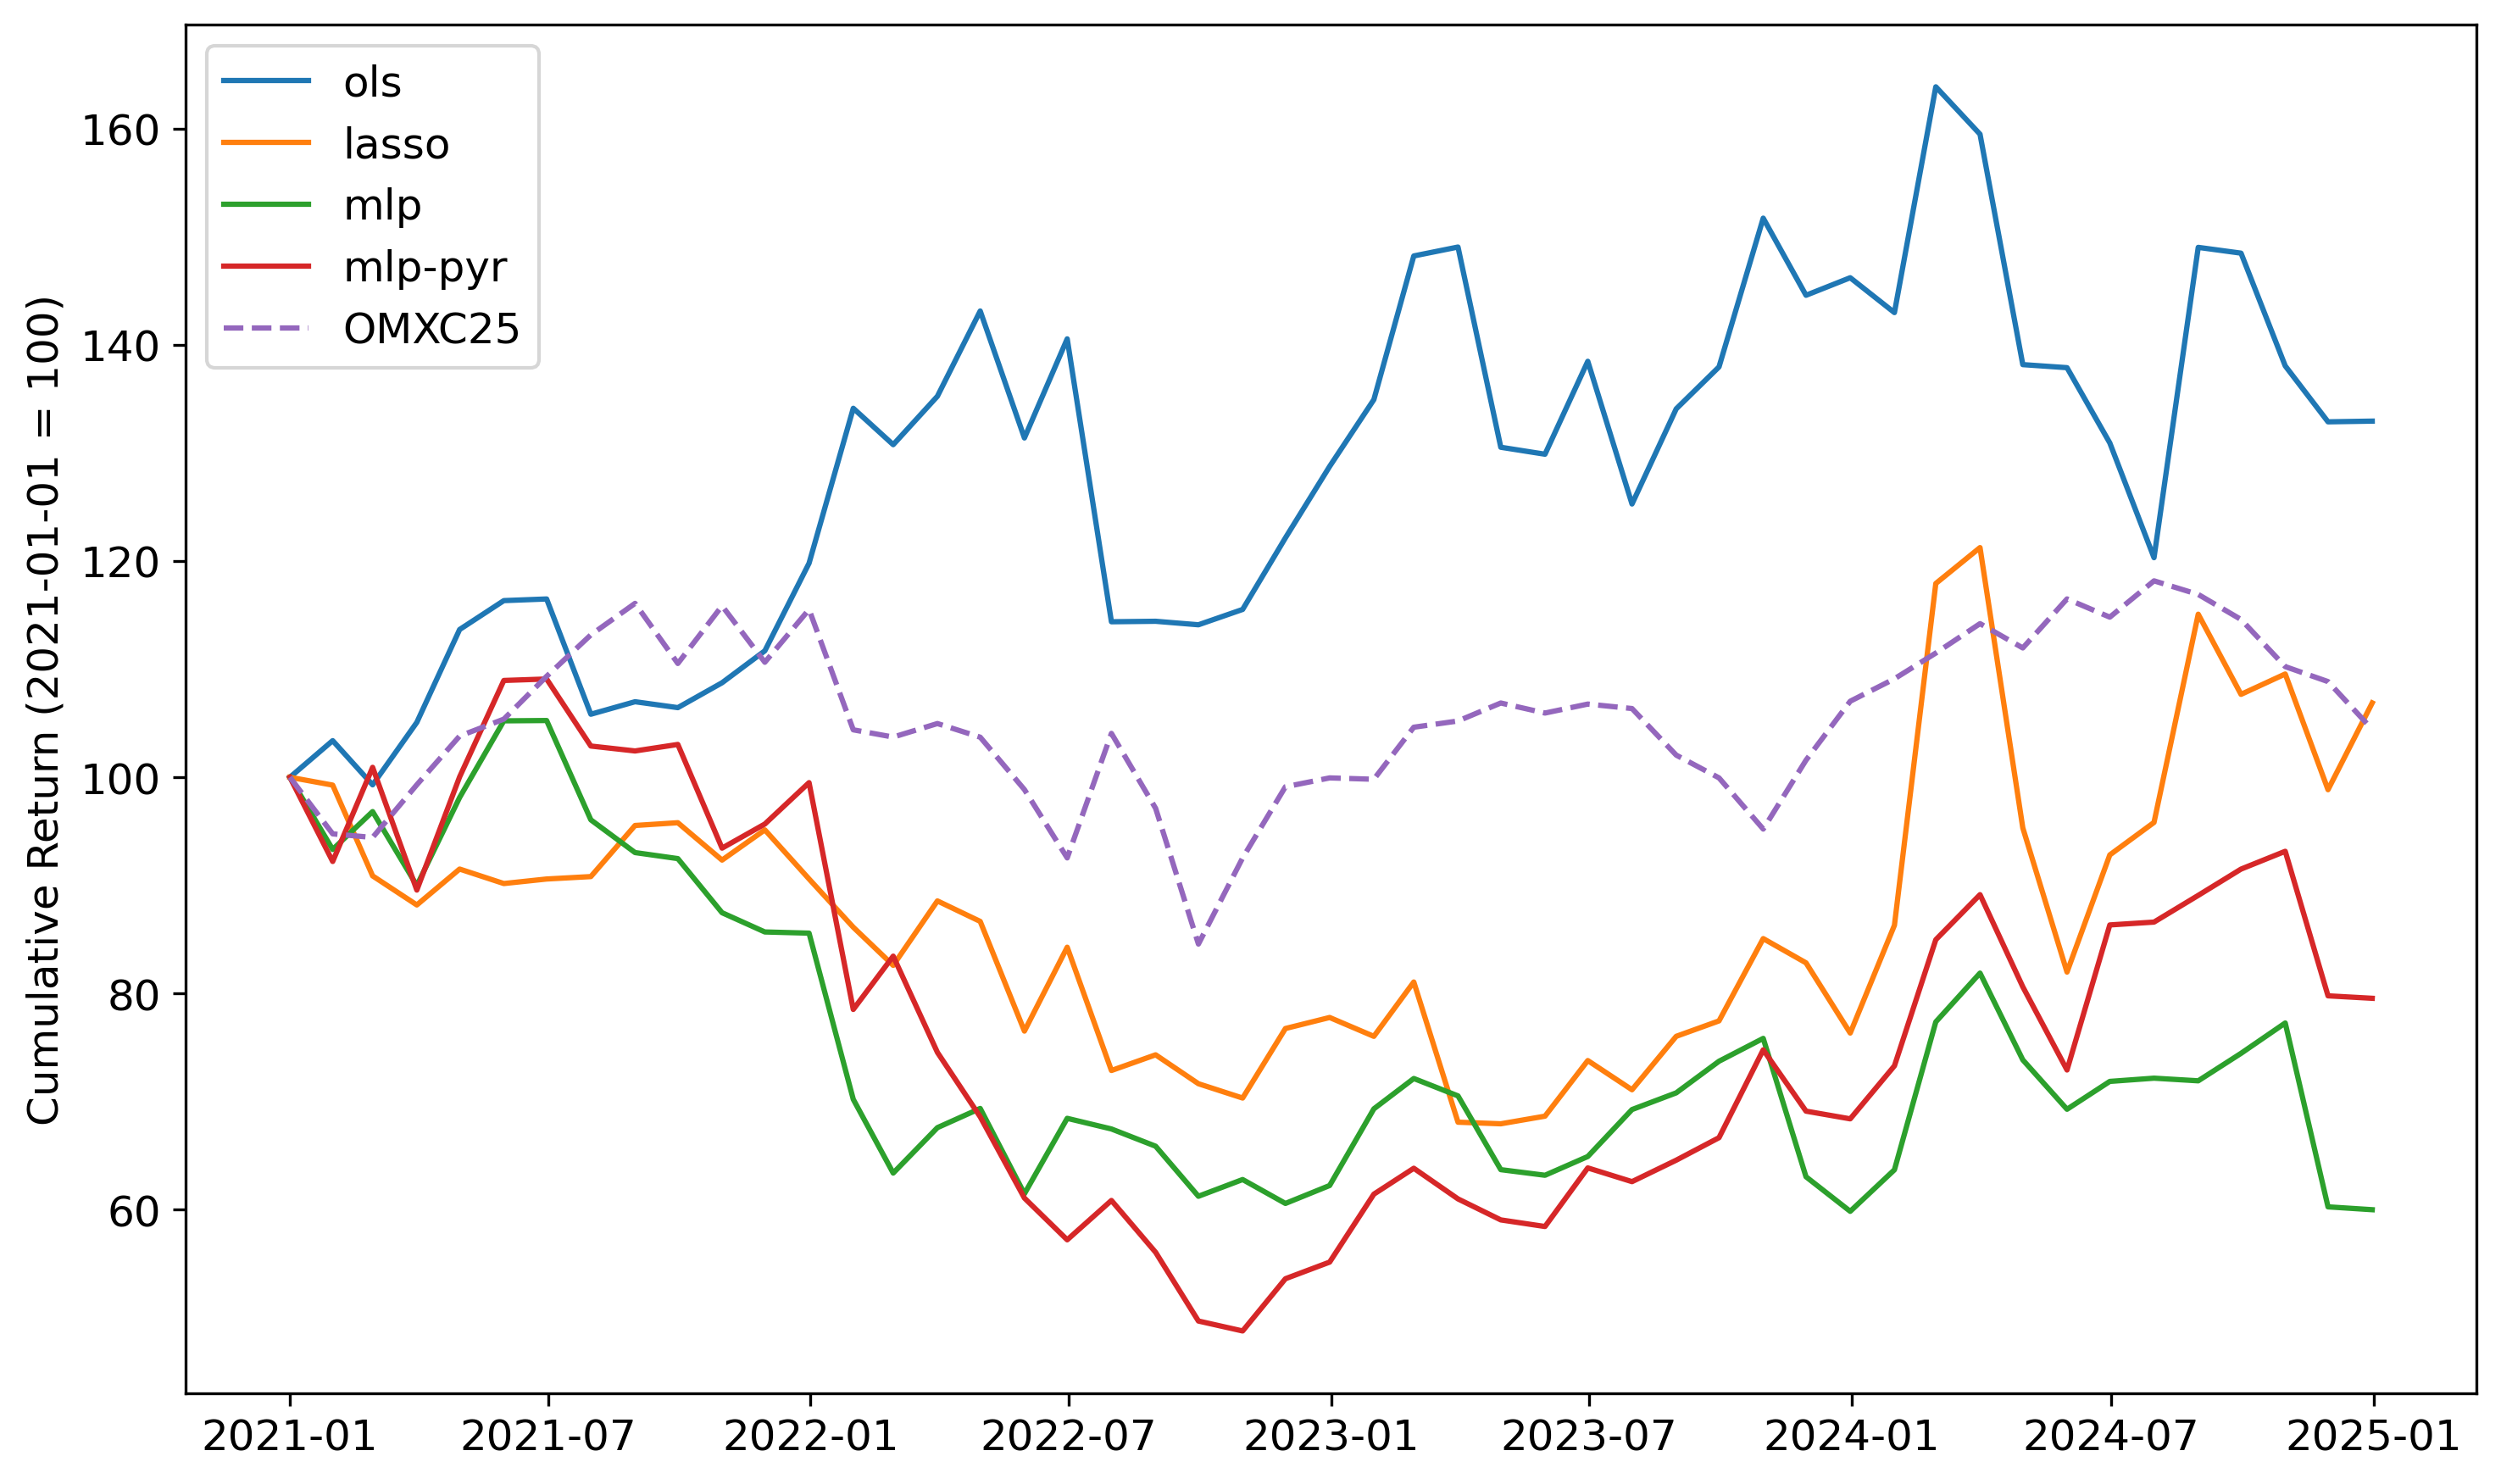

In [6]:
# plotting
plt.figure(figsize=(10, 6))
for model in models.keys():
    plt.plot(port_10_1['timestamp'], port_10_1[f'{model}_return_cum'], label=model)
plt.plot(omxc25_price['timestamp'], omxc25_price['rebased'], label='OMXC25', linestyle='--')
# plt.plot(omxcb_price['timestamp'], omxcb_price['rebased'], label='OMXCB', linestyle='--')
# plt.title('Cumulative Returns by Model')
# plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return (2021-01-01 = 100)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Sign-only

In [7]:
port_directional = pd.DataFrame()

for model in models.keys():
    tmp = df.copy(deep=True)
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, np.where(np.sign(tmp[model]) == -1, -1, 0))
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, -1)

    tmp['n_short'] = (tmp['action'] == -1).astype(int)
    tmp['n_long'] = (tmp['action'] == 1).astype(int)

    tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
    tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')


    tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],
                        np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'], 0))
    # pure one directional strategy
    tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],0)
    # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'],0)

    tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
    tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
    tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
    tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1
    
    port_directional = pd.concat([port_directional, tmp], axis=1)
port_directional = port_directional.loc[:, ~port_directional.columns.duplicated()]
port_directional.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
port_directional = port_directional.sort_index().reset_index(drop=True)

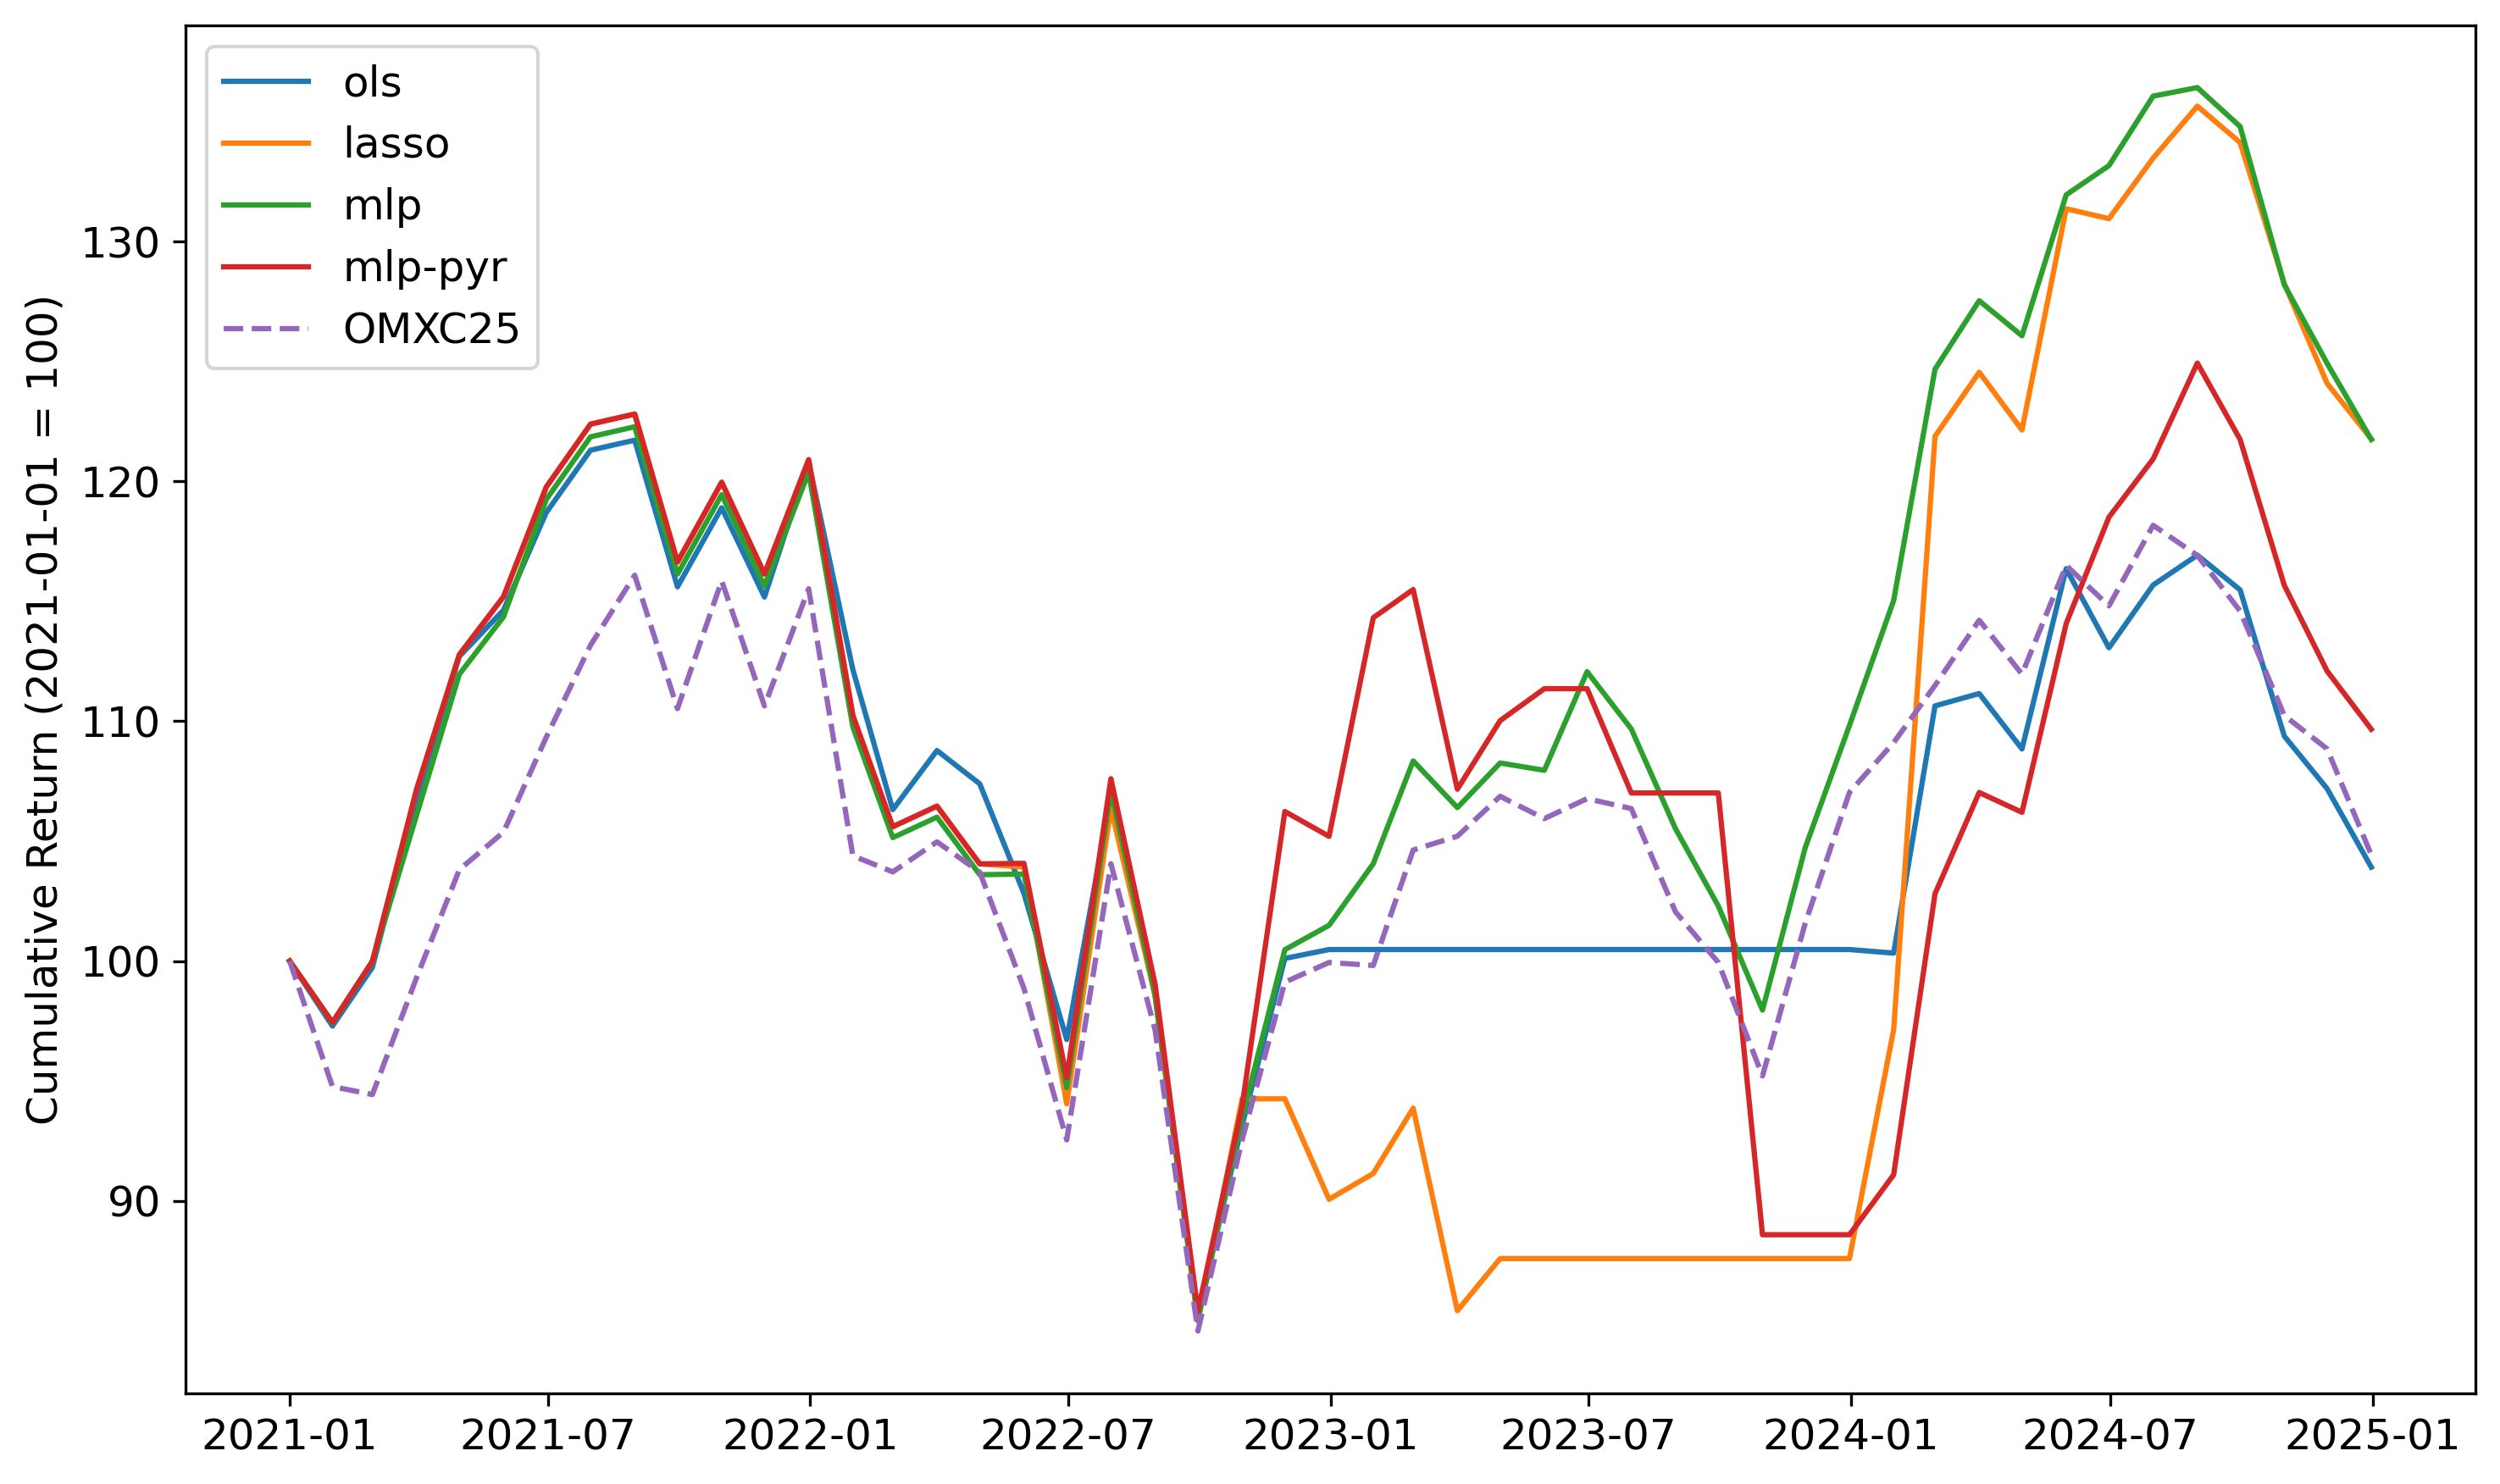

In [8]:
# plotting
plt.figure(figsize=(10, 6))
for model in models.keys():
    plt.plot(port_directional['timestamp'], port_directional[f'{model}_return_cum'], label=model)
plt.plot(omxc25_price['timestamp'], omxc25_price['rebased'], label='OMXC25', linestyle='--')
# plt.plot(omxcb_price['timestamp'], omxcb_price['rebased'], label='OMXCB', linestyle='--')
# plt.title('Cumulative Returns by Model')
# plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return (2021-01-01 = 100)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()